# Chapter 5

In [20]:
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import ptitprince as pt
import scipy.stats as stats

In [7]:
az.style.use('arviz-darkgrid')

### Load the data "WaffleDivorce"

In [8]:
df = pd.read_csv('../resources/Rethinking/Data/WaffleDivorce.csv', sep = ';')

In [9]:
df.head(3)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00


In [10]:
df.tail(3)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
47,West Virginia,WV,1.85,25.0,22.2,1.69,10.9,1.34,4,1,18371,376688,0.049
48,Wisconsin,WI,5.69,26.3,17.2,0.79,8.3,0.57,0,0,0,775881,0.000
49,Wyoming,WY,0.56,24.2,30.7,3.92,10.3,1.90,0,0,0,0,0.000


In [12]:
df['MedianAgeMarriage_s'] = (df['MedianAgeMarriage']-df['MedianAgeMarriage'].mean())/df['MedianAgeMarriage'].std()

In [14]:
df['Divorce_s'] = (df['Divorce'] - df['Divorce'].mean())/df['Divorce'].std()

In [151]:
df['Marriage_s'] = (df['Marriage'] - df['Marriage'].mean())/df['Marriage'].std()

In [15]:
df.head(2)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,MedianAgeMarriage_s,Divorce_s
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45,-0.606290,1.654205
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00,-0.686699,1.544364


### Linear regression model with median age of marriage as predictor for divorce:

$$ D_i \sim N(\mu_i, \sigma) $$
$$ \mu_i = \alpha + \beta_A A_i $$
$$ \alpha \sim N(0, 0.2) $$
$$ \beta_A \sim N(0, 0.5) $$ 
$$ \sigma \sim Exp(1) $$

## Choosing priors

In [16]:
df['MedianAgeMarriage'].std()

1.243630301388082

Slope of 1 would mean that 1 year difference in median age of marriage would cause a 1 standard deviation difference in divorce rates: implausible.

### Sample with MCMC using pymc3:

In [18]:
with pm.Model() as model_51:
    alpha = pm.Normal('alpha', 0, 0.2)
    beta = pm.Normal('beta', 0, 0.5)
    sigma = pm.Exponential('sigma', 1)
    mu = pm.Deterministic('mu', alpha + beta * df['MedianAgeMarriage_s'])
    D_i = pm.Normal('Divorce', mu, sigma, observed = df['Divorce_s'])
    trace_51 = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:05<00:00, 1378.66draws/s]


### Visualize results by taking a random sample of fits

In [60]:
trace_df = pm.trace_to_dataframe(trace_51)

In [61]:
len(trace_51['alpha'])

4000

In [77]:
row = np.random.choice(4000, 500)

In [78]:
x = np.linspace(-3,3,100)

In [79]:
y =  trace_df['alpha'][row].values + np.outer(x,trace_df['beta'][row].values)

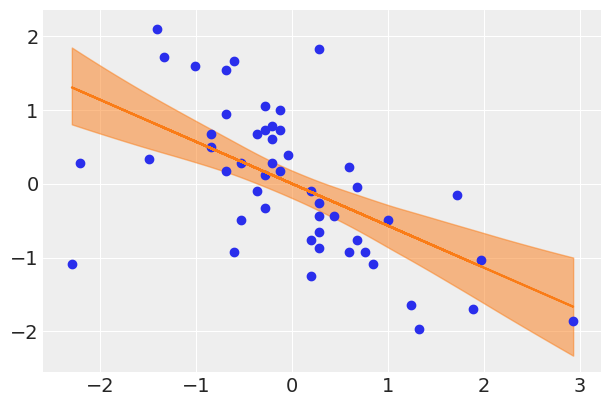

In [92]:
az.plot_hpd(df['MedianAgeMarriage_s'], trace_51['mu'])
plt.scatter(df['MedianAgeMarriage_s'], df['Divorce_s'])
plt.plot(df['MedianAgeMarriage_s'], trace_51['alpha'].mean() + trace_51['beta'].mean()* df['MedianAgeMarriage_s'], c ='C1')

### Drawing Directed Acyclic Diagrams (DAG)

In [93]:
import networkx as nx

In [119]:
G = nx.DiGraph()

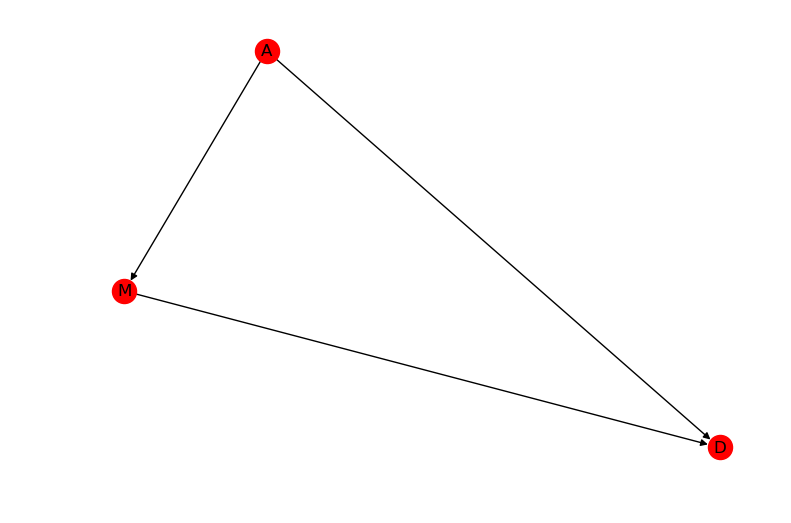

In [149]:

G.add_node('A')
G.add_node('M')
G.add_node('D')

G.add_edge('A','M')
G.add_edge('A','D')
G.add_edge('M','D')

pos=nx.spring_layout(G)
nx.draw(G, pos , with_labels = True)

### New model with multiple regression

$$ D_i \sim N(\mu_i, \sigma) $$
$$ \mu_i = \alpha  + \beta_A A_i + \beta_M  M_i$$
$$ \alpha \sim N(0, 0.02) $$
$$ \beta_M \sim N(0,0.5) $$
$$ \beta_A \sim N(0,0.5) $$
$$ \sigma \sim Exp(1) $$

### Estimating the posterior

In [153]:
with pm.Model() as model_52:
    sigma = pm.Exponential('sigma',1)
    alpha = pm.Normal('alpha', 0,0.02)
    beta_a = pm.Normal('beta_a', 0,0.5)
    beta_m = pm.Normal('beta_m', 0, 0.5)
    mu = pm.Deterministic('mu', alpha+beta_a*df['MedianAgeMarriage_s'] +beta_m*df['Marriage_s'])
    divorces = pm.Normal('divorce', mu, sigma, observed = df['Divorce_s'])
    trace_52 = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_m, beta_a, alpha, sigma]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:05<00:00, 1412.79draws/s]


In [157]:
var_names = '~mu'

GridSpec(1, 2, width_ratios=[3, 1])

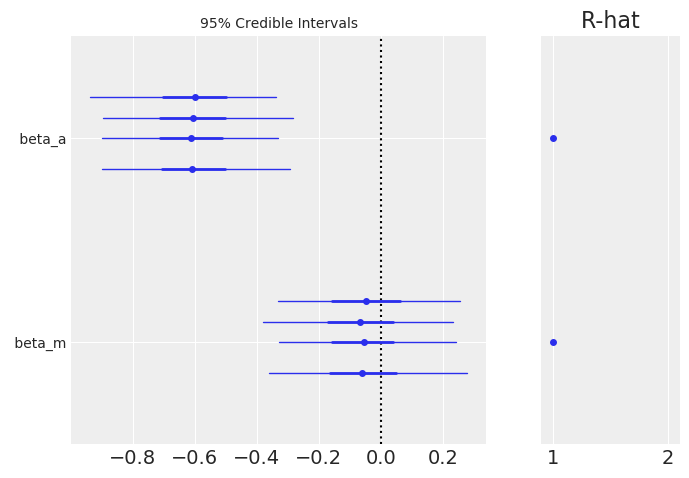

In [162]:
pm.forestplot(trace_52, varnames=['beta_a', 'beta_m'])

### Effect of marriage rate alone on divorce

$$ M_i \sim N(\mu_i, \sigma) $$
$$ \mu_i = \alpha + \beta * A_i $$
$$ \alpha \sim N(0, 0.02) $$
$$ \beta \sim N(0,0.5) $$
$$ \sigma \sim Exp(1) $$

In [169]:
with pm.Model() as model_53:
    sigma = pm.Exponential('sigma', 1)
    alpha = pm.Normal('alpha', 0,0.02)
    beta = pm.Normal('beta', 0, 0.5)
    mu = pm.Deterministic('mu', alpha + beta * df['MedianAgeMarriage_s'])
    marriage = pm.Normal('marriage', mu, sigma, observed = df['Marriage_s'])
    trace_53 = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, sigma]
Sampling 4 chains: 100%|██████████████████████████████████████████████████████| 8000/8000 [00:04<00:00, 1749.17draws/s]


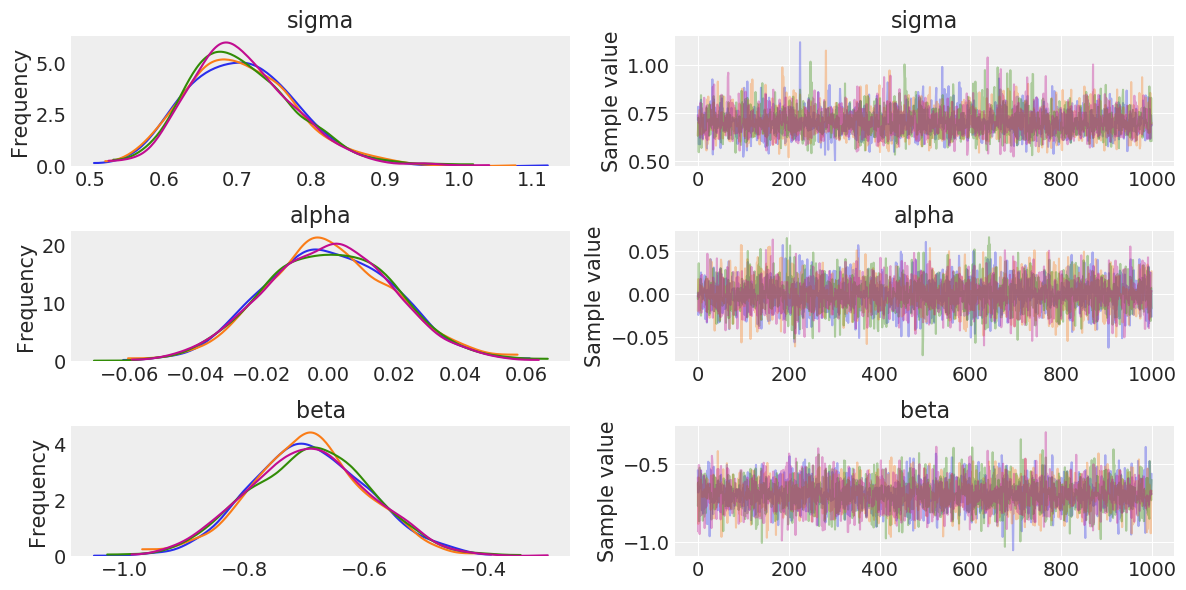

In [172]:
pm.traceplot(trace_53, varnames=['sigma','alpha','beta']);

In [257]:
mu_pred = trace_53['mu'].mean(0)
mu_residual = df['Marriage_s'] - mu_pred

In [258]:
idx = np.argsort(df['MedianAgeMarriage_s'])

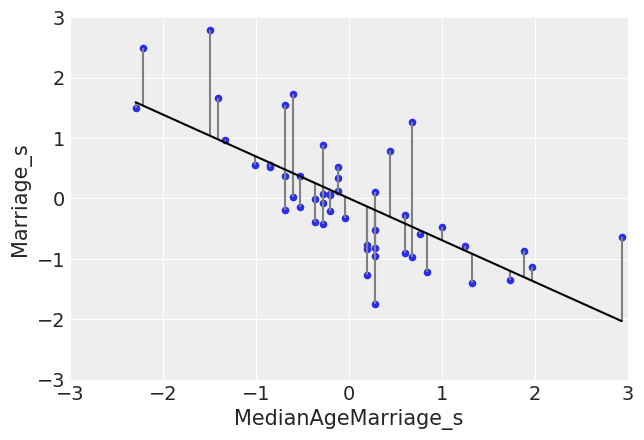

In [265]:
df.plot('MedianAgeMarriage_s', 'Marriage_s', kind='scatter', xlim=(-3,3), ylim=(-3,3))
plt.plot(df['MedianAgeMarriage_s'][idx], trace_53['alpha'].mean() + trace_53['beta'].mean() * df['MedianAgeMarriage_s'][idx], 'k');
plt.vlines(df['MedianAgeMarriage_s'], mu_pred, mu_pred + mu_residual, colors ='grey')

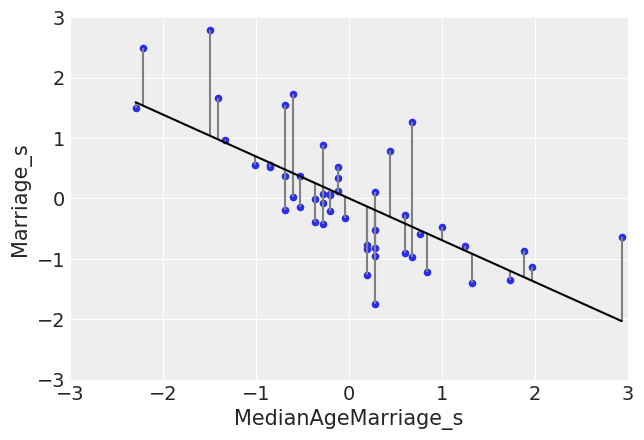

In [270]:
df.plot('MedianAgeMarriage_s', 'Marriage_s', kind='scatter', xlim=(-3,3), ylim=(-3,3))
plt.plot(df['MedianAgeMarriage_s'][idx], trace_53['alpha'].mean() + trace_53['beta'].mean() * df['MedianAgeMarriage_s'][idx], 'k');
plt.vlines(df['MedianAgeMarriage_s'], mu_pred, mu_pred + mu_residual, colors ='grey')